In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, SpectralClustering, FeatureAgglomeration, DBSCAN, AgglomerativeClustering

In [2]:
#set up the seed and seaborn preferences
SEED = 1234
sns.set_theme(context='notebook', style='darkgrid', palette='bright')

In [3]:
#load data
df = pd.read_csv("../data/data_aba/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#types of data
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
non_cat_variables = ['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [7]:
#basic statistics
df[df.columns.difference(non_cat_variables)].describe()

,Churn,Contract,Dependents,DeviceProtection,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,PhoneService,StreamingMovies,StreamingTV,TechSupport,TotalCharges,customerID,gender
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,3,2,3,3,3,3,3,2,2,4,2,3,3,3,6531,7043,2
top,No,Month-to-month,No,No,Fiber optic,No,No,No,Yes,No,Electronic check,Yes,No,No,No,,6982-SSHFK,Male
freq,5174,3875,4933,3095,3096,3390,3088,3498,4171,3641,2365,6361,2785,2810,3473,11,1,3555


In [8]:
df[non_cat_variables].describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
df = df.drop('customerID', axis=1)

In [10]:
columns_for_count_plot = df.columns.difference(non_cat_variables).to_list()

In [11]:
columns_for_count_plot.remove('TotalCharges')
columns_for_count_plot.append('SeniorCitizen')

In [12]:
#change datatype of 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
#change values of 'SeniorCitizen'
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: "Yes" if x == 1 else "No")

In [13]:
#NaN values
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

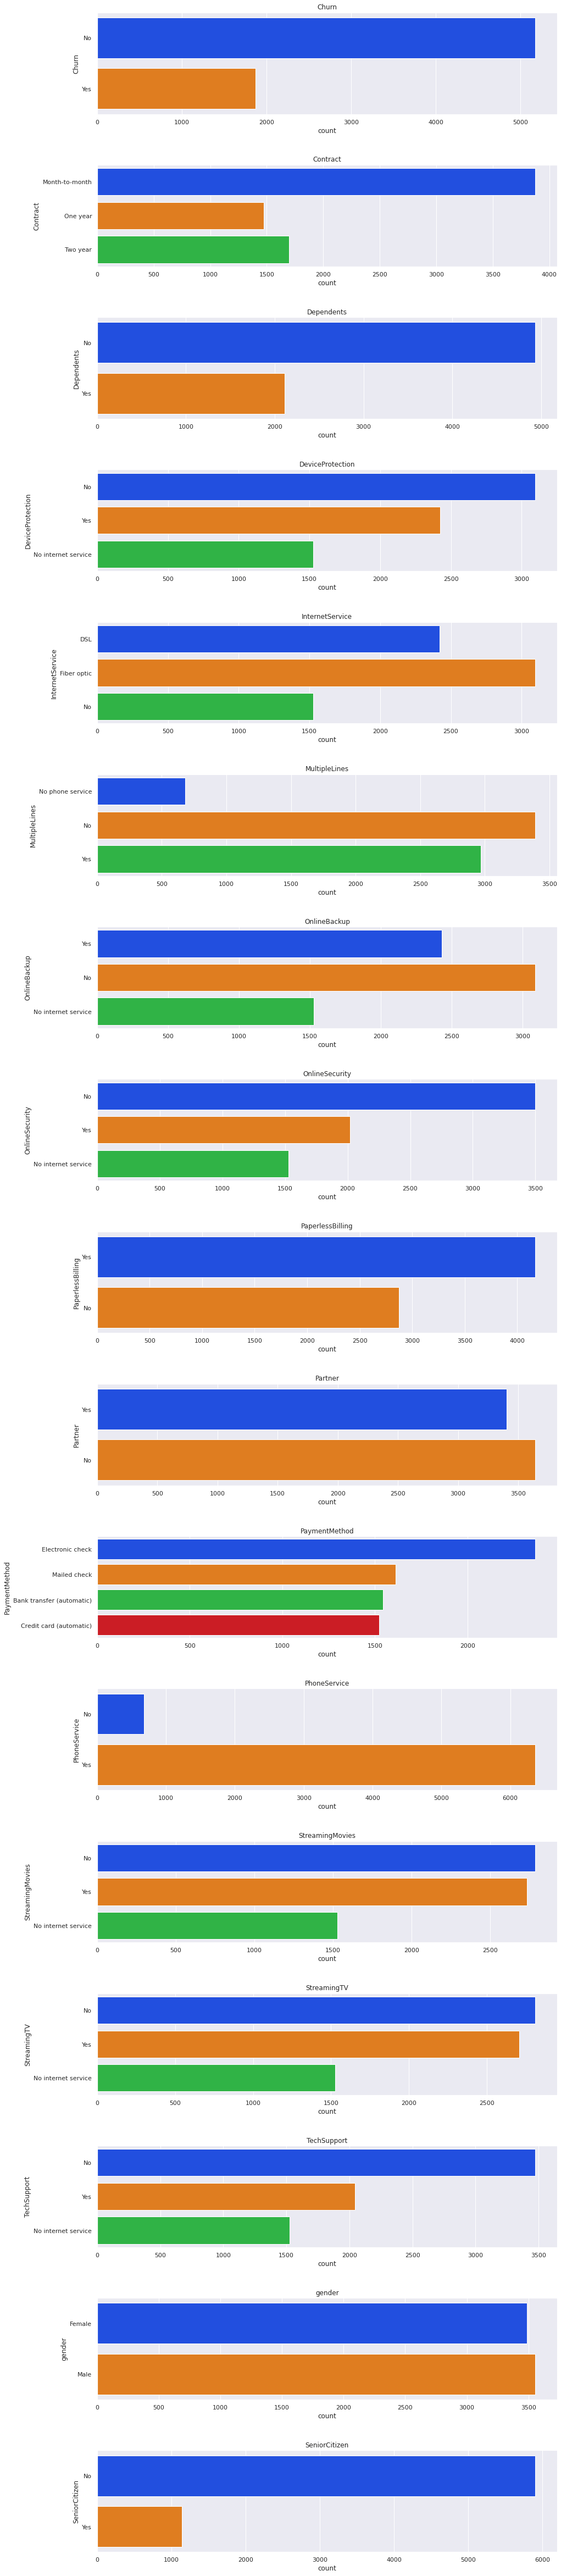

In [14]:
#plots
fig, ax = plt.subplots(nrows=17, ncols=1, figsize=(15, 85))
fig.subplots_adjust(hspace=.5)
plt.title('Countplot: categorical variables')

for i, col in enumerate(columns_for_count_plot):
    sns.countplot(data = df, y = col, ax = ax[i])
    ax[i].set_title('{}'.format(col))

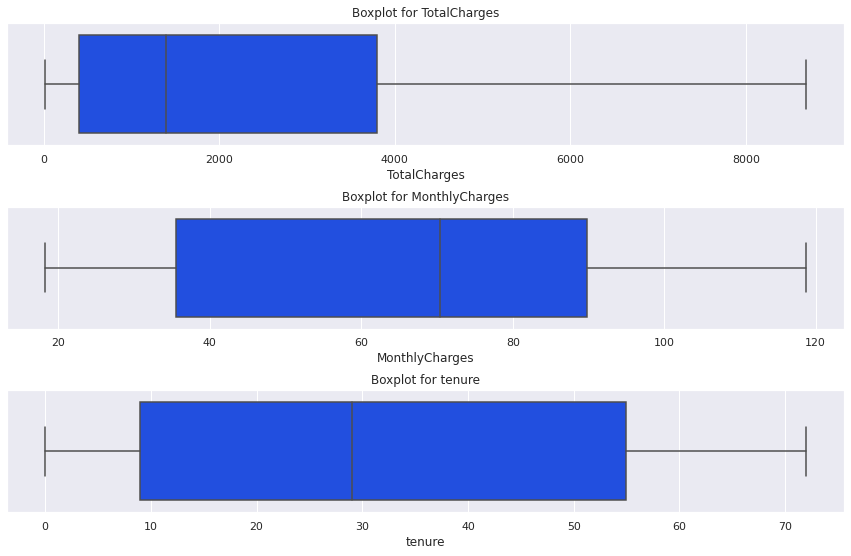

In [15]:
columns_for_box_plot = ['TotalCharges', 'MonthlyCharges', 'tenure']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 9)) # create subplots
fig.subplots_adjust(hspace=.5) # adjust space between plots
for i, col in enumerate(columns_for_box_plot):
    sns.boxplot(data=df, x=df[col], ax=ax[i])
    ax[i].set_title('Boxplot for {}'.format(col))

In [16]:
#fillna in TotalCharges with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [17]:
y = df['Churn']
df = df.drop(['Churn'], axis=1)

In [18]:
#convert categorical variables
df_converted = pd.get_dummies(df)
df_converted.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [19]:
#standartize the varaibles
transformer = StandardScaler().fit(df_converted)
scaled = transformer.transform(df_converted)
X_transform = pd.DataFrame(scaled, columns=df_converted.columns)
X_transform.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.994971,1.009559,-1.009559,0.439916,-0.439916,-1.034530,1.034530,0.654012,...,-0.79607,0.904184,-0.514249,-0.562975,-0.829798,0.829798,-0.529885,-0.525047,1.406418,-0.544807
1,0.066327,-0.259629,-0.173876,-0.990532,0.990532,0.439916,-0.439916,0.966622,-0.966622,0.654012,...,-0.79607,-1.105970,1.944582,-0.562975,1.205113,-1.205113,-0.529885,-0.525047,-0.711026,1.835513
2,-1.236724,-0.362660,-0.960399,-0.990532,0.990532,0.439916,-0.439916,0.966622,-0.966622,0.654012,...,-0.79607,0.904184,-0.514249,-0.562975,-0.829798,0.829798,-0.529885,-0.525047,-0.711026,1.835513
3,0.514251,-0.746535,-0.195400,-0.990532,0.990532,0.439916,-0.439916,0.966622,-0.966622,0.654012,...,-0.79607,-1.105970,1.944582,-0.562975,1.205113,-1.205113,1.887201,-0.525047,-0.711026,-0.544807
4,-1.236724,0.197365,-0.941193,1.009559,-1.009559,0.439916,-0.439916,0.966622,-0.966622,0.654012,...,-0.79607,0.904184,-0.514249,-0.562975,-0.829798,0.829798,-0.529885,-0.525047,1.406418,-0.544807


In [20]:
#strange bug(((
pca = PCA(n_components=2, random_state=SEED)
pca.fit(X_transform)

PCA(n_components=2, random_state=1234)

In [21]:
X_pca = pca.transform(X_transform)

In [22]:
X_pca = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])

In [23]:
X_pca['Churn'] = y

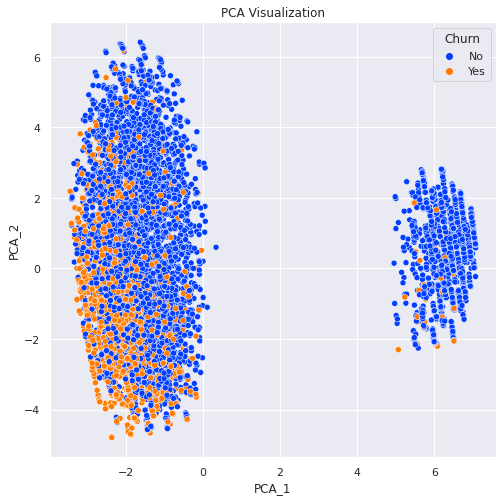

In [24]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='Churn').set_title('PCA Visualization');

In [25]:
%%time
tsne = TSNE(random_state=SEED, n_jobs=-1)
X_tsne = tsne.fit_transform(X_transform)

CPU times: user 1min 54s, sys: 3.3 s, total: 1min 57s
Wall time: 32.6 s


In [26]:
X_tsne = pd.DataFrame(X_tsne , columns=['TSNE_1', 'TSNE_2'])
X_tsne['Churn'] = y

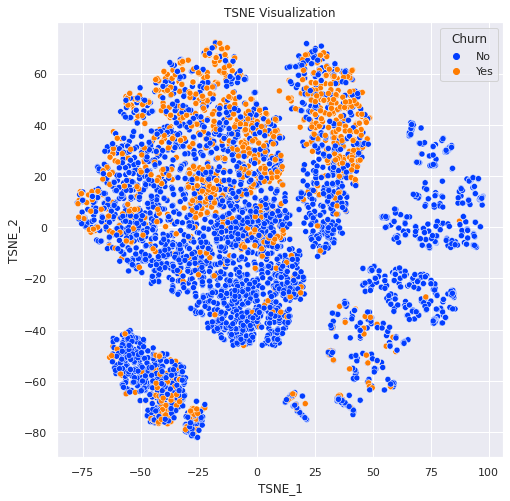

In [27]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='Churn').set_title('TSNE Visualization');

In [28]:
#select the number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_transform)
    inertia.append(np.sqrt(kmeans.inertia_))
# interia - sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided

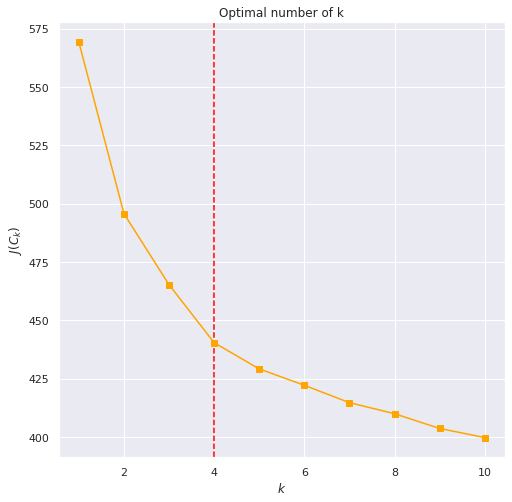

In [29]:
plt.figure(figsize=(8, 8)) 
plt.axvline(x=4, color="red", linestyle='--',)
plt.plot(range(1, 11), inertia, marker='s', color="orange");
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('Optimal number of k');

In [39]:
kmeans = KMeans(n_clusters=4, random_state=SEED).fit(X_transform)
labels = kmeans.labels_
labels += 1

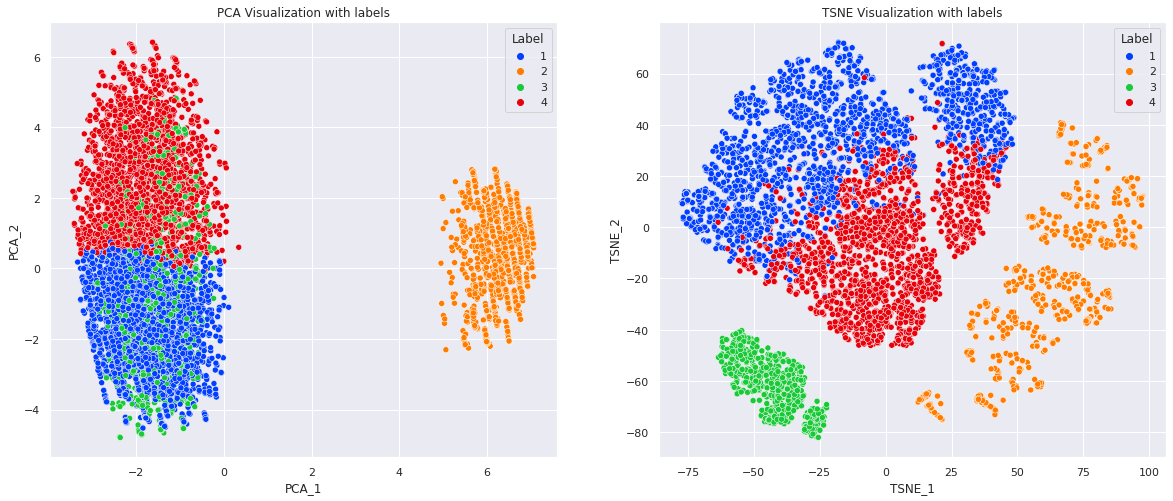

In [40]:
#add labels to visualization
X_pca['Label'] = labels
X_tsne['Label'] = labels
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='Label', ax=axes[0],
                palette='bright').set_title('PCA Visualization with labels');
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='Label', ax=axes[1],
                palette='bright').set_title('TSNE Visualization with labels');

In [38]:
#other algorithms and metrics
algorithms = []
algorithms.append(KMeans(n_clusters=4, random_state=SEED))
# algorithms.append(AffinityPropagation(random_state=SEED)) #slow!!! 
# algorithms.append(SpectralClustering(n_clusters=4, random_state=SEED, n_jobs=-1)) #slow!!!!
# algorithms.append(FeatureAgglomeration(n_clusters=4)) #slow!!!
algorithms.append(AgglomerativeClustering(n_clusters=4))
algorithms.append(DBSCAN(eps=0.8)) #small dataset for DBSCAN


data = []
for algo in tqdm(algorithms):
    algo.fit(X_transform)
    data.append(({
        'Silhouette Score': metrics.silhouette_score(X_transform, algo.labels_, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_transform, algo.labels_),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_transform, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
                       index=['K-means', 'AgglomerativeClustering', 'DBSCAN'])
# Silhouette Score - The best value is 1 and the worst value is -1.
# higher Calinski-Harabasz score relates to a model with better defined clusters.
# Davies-Bouldin Score: values closer to zero indicate a better partition.
results

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]


,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
K-means,0.222147,1572.317313,1.848713
AgglomerativeClustering,0.188938,1390.858158,2.206448
DBSCAN,-0.167005,16.356026,0.991197


In [81]:
df_plus = pd.DataFrame()
df_plus['Churn'] = y
df_plus['Label'] = labels

In [86]:
df_plus.groupby(['Label', 'Churn']).size()

Label  Churn
1      No       1452
       Yes      1285
2      No       1413
       Yes       113
3      No        512
       Yes       170
4      No       1797
       Yes       301
dtype: int64